# Hospital placement set covering problem: Basic model

Plan:
1. Place equidistant points on a map of Vancouver to indicate possible locations for "hospitals"
2. Consider each of these points as location that must be covered as well
3. Run the set covering algorithm to see what happens

In [2]:
!! pip3 install -U numpy scipy
!! pip3 install -U googlemaps
!! pip3 install -U requests

['Requirement already up-to-date: requests in /home/lily/.local/lib/python3.8/site-packages (2.28.1)',
 'Requirement already satisfied, skipping upgrade: urllib3<1.27,>=1.21.1 in /home/lily/.local/lib/python3.8/site-packages (from requests) (1.26.2)',
 'Requirement already satisfied, skipping upgrade: certifi>=2017.4.17 in /home/lily/.local/lib/python3.8/site-packages (from requests) (2020.12.5)',
 'Requirement already satisfied, skipping upgrade: idna<4,>=2.5 in /home/lily/.local/lib/python3.8/site-packages (from requests) (2.10)',
 'Requirement already satisfied, skipping upgrade: charset-normalizer<3,>=2 in /home/lily/.local/lib/python3.8/site-packages (from requests) (2.1.1)']

In [3]:
import googlemaps
import requests
from IPython.display import display, Image
import math
import numpy as np
from scipy.optimize import linprog

api_key = open("googlemaps-apikey.txt", "r").read()
client = googlemaps.Client(key=api_key)


In [4]:
def display_map(center, markers=[], zoom=13, fill=False):
    static_map_url = "https://maps.googleapis.com/maps/api/staticmap?"
    lat,long = center
    center = str(lat)+","+str(long)
    req = f"{static_map_url}center={center}&zoom={str(zoom)}&size=400x400&key={api_key}&sensor=false"
    if fill:
        path = "&path=color:0x00000000|weight:5|fillcolor:0x58FF33|" + "|".join([str(lat)+","+str(long) for lat,long in markers])
        marker = f"&markers=color:green|{center}"
        req = req + path + marker
    else:
        markers = "&markers=color:blue|" + "|".join([str(lat)+","+str(long) for lat,long in markers])
        req = req + markers
    # print(req)
    r = requests.get(req)
    if "X-Staticmap-API-Warning" in r.headers:
        print(r.headers["X-Staticmap-API-Warning"])
    display(Image(r.content))

In [41]:
# parsing the distance matrix
# times = client.distance_matrix(origins=center, destinations=circle)
# print("\n".join([str([elt["duration"]["text"] for elt in row["elements"]]) for row in times["rows"]]))

# lat,long -> encoded polyline representing the region
def distance_coverable(center):
    n = 15
    r = 0.02
    def circle_offsets():
        offsets =[]
        for i in range(n):
            deg = i/n * 2 * math.pi
            offsets.append([math.cos(deg)*r, math.sin(deg)*r])
        return offsets

    circle = [[center[0] + offset[0], center[1] + offset[1]] for offset in circle_offsets()]
    # display_map(center, markers=circle,zoom=11, fill=True)
    unchanged = False
    # center_str = str(center[0]) + "," + str(center[1])
    max_iterations = 20
    num_iter = 0
    while num_iter < max_iterations and not unchanged:
        num_iter += 1
        unchanged = True
        times = client.distance_matrix(origins=center, destinations=circle)
        matrix = [[elt["duration"]["value"] for elt in row["elements"]] for row in times["rows"]]
        pairs = zip(circle, matrix[0])
        circle = []
        for i, ((lat, long), time) in enumerate(pairs):
            nine_mins = 9*60
            eleven_mins = 11*60
            deg = i/n * 2 * math.pi
            old_r = (lat - center[0])/math.cos(deg)
            if time < nine_mins:
                new_r = old_r * 1.1
                circle.append([center[0] +math.cos(deg)*new_r, center[1] + math.sin(deg)*new_r])
                unchanged = False
            elif time > eleven_mins:
                new_r = old_r * 0.9
                circle.append([center[0] +math.cos(deg)*new_r, center[1] + math.sin(deg)*new_r])
                unchanged = False
            else:
                circle.append([lat,long])
    print(f"iterations taken = {num_iter}")
    display_map(center, markers=circle,zoom=11, fill=True)


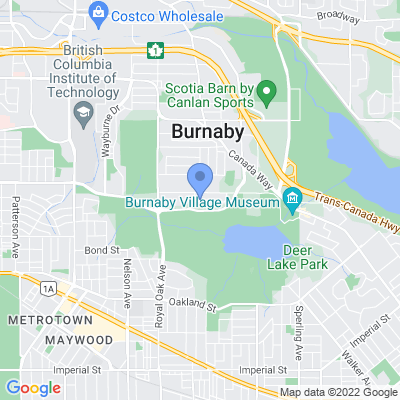

iteration = 0
iteration = 1
iteration = 2
iteration = 3
iteration = 4
iteration = 5
iteration = 6
iteration = 7
iteration = 8
iteration = 9


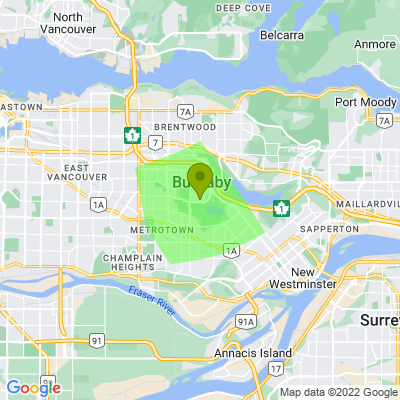

In [9]:
test_positions_burnaby = [
    (49.240982, -122.981740)
]

display_map((49.240982, -122.981740), markers=test_positions_burnaby)
distance_coverable((49.240982, -122.981740))

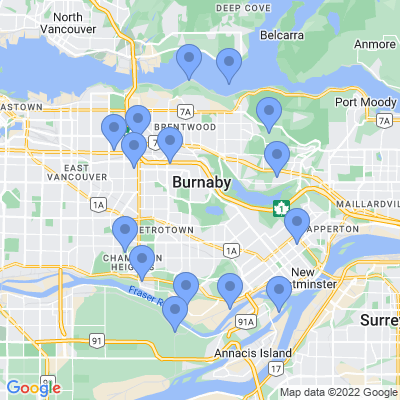

[[49.254809, -123.027128], [49.220775, -122.915086], [49.191846, -122.991347], [49.266699, -123.024156], [49.270362, -122.934271], [49.19138, -122.961141], [49.181391, -122.998782], [49.217235, -123.032945], [49.250999, -122.929083], [49.257068, -123.002124], [49.204169, -123.021163], [49.292459, -122.961662], [49.190125, -122.92744], [49.262709, -123.04054], [49.294365, -122.989042]]


In [66]:
import random 
test_problem_burnaby_center = (49.240982, -122.981740)
n = 15
test_problem_burnaby_locations = [[round(test_problem_burnaby_center[0] + random.uniform(-0.07, 0.07), 6), round(test_problem_burnaby_center[1] + random.uniform(-0.07, 0.07), 6)] for _ in range(n)]
display_map(test_problem_burnaby_center, markers=test_problem_burnaby_locations,zoom=11.5)
print(test_problem_burnaby_locations)


In [67]:
def make_set_covering_problem(positions):
    positions = [str(lat) + "," + str(long) for lat,long in positions]
    covering_matrix = np.array([])
    ten_mins = 60*10
    for start in positions:
        # print(f"starting from {start}")
        matrix = client.distance_matrix(origins=start, destinations=positions)
        times = [[elt["duration"]["value"] for elt in row["elements"]] for row in matrix["rows"]][0]
        covered = [1 if t < ten_mins else 0 for t in times]
        covering_matrix = np.hstack((covering_matrix, covered))
    return covering_matrix.reshape(len(positions), len(positions))

In [68]:
matrix = make_set_covering_problem(test_problem_burnaby_locations)
print(matrix)

starting from 49.254809,-123.027128
starting from 49.220775,-122.915086
starting from 49.191846,-122.991347
starting from 49.266699,-123.024156
starting from 49.270362,-122.934271
starting from 49.19138,-122.961141
starting from 49.181391,-122.998782
starting from 49.217235,-123.032945
starting from 49.250999,-122.929083
starting from 49.257068,-123.002124
starting from 49.204169,-123.021163
starting from 49.292459,-122.961662
starting from 49.190125,-122.92744
starting from 49.262709,-123.04054
starting from 49.294365,-122.989042
[[1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 1.

In [69]:
c = np.ones(len(test_problem_burnaby_locations))
b = -np.ones(len(test_problem_burnaby_locations))
A = -matrix
bounds = [(0,1) for _ in test_problem_burnaby_locations]
print(A)
print(b)
print(c)
solution = linprog(c, A_ub=A, b_ub=b, bounds=bounds, integrality=np.ones(len(test_problem_burnaby_locations)))
print(solution)
linprog_solution = []
for i,chosen in enumerate(solution.x):
    if chosen == 1:
        linprog_solution.append(i)
print(linprog_solution)

[[-1. -0. -0. -1. -0. -0. -0. -0. -0. -1. -0. -0. -0. -1. -0.]
 [-0. -1. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -1. -0. -0. -1. -0. -0. -0. -0. -1. -0. -0. -0. -0.]
 [-1. -0. -0. -1. -0. -0. -0. -0. -0. -1. -0. -0. -0. -1. -0.]
 [-0. -0. -0. -0. -1. -0. -0. -0. -1. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -1. -0. -0. -1. -0. -0. -0. -0. -0. -0. -1. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -1. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -1. -0. -0. -0. -0. -1. -0. -0. -1. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -1. -0. -0. -0. -1. -0. -0. -0. -0. -0. -0.]
 [-1. -0. -0. -1. -0. -0. -0. -0. -0. -1. -0. -0. -0. -1. -0.]
 [-0. -0. -1. -0. -0. -1. -0. -1. -0. -0. -1. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -1. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -1. -0. -0.]
 [-1. -0. -0. -1. -0. -0. -0. -0. -0. -1. -0. -0. -0. -1. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -1.]]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -

In [75]:
def display_solution(center, problem, chosen_indicies, show_coverage=False):
    chosen_points = []
    for i in chosen_indicies:
        if show_coverage:
            # googlemaps requires this to be a tuple... weird
            lat,long = problem[i]
            distance_coverable((lat, long))
        chosen_points.append(problem[i])
    print(chosen_points)
    display_map(center, markers=problem,zoom=11.5)
    display_map(center, markers=chosen_points,zoom=11.5)

In [94]:
# greedy solver -> alternative to linprog to see if it makes a difference

def greedy_solve(matrix):
    taken = []
    internal = np.copy(matrix)
    while internal.shape[0] != 0:
        # print(internal)
        values = np.sum(internal, axis=0)
        choice = np.argmax(values)
        taken.append(choice)
        # remove the rows that are now covered
        covered = internal[:,choice]
        to_delete = []
        for i,is_covered in enumerate(covered):
            if is_covered == 1:
                to_delete.append(i)
        internal = np.delete(internal, to_delete, axis=0)
        # remove the column for this choice
        # internal = np.delete(internal, (choice), axis=1)
    return sorted(taken)

[0, 1, 2, 4, 6, 11, 12, 14]
[[49.254809, -123.027128], [49.220775, -122.915086], [49.191846, -122.991347], [49.270362, -122.934271], [49.181391, -122.998782], [49.292459, -122.961662], [49.190125, -122.92744], [49.294365, -122.989042]]


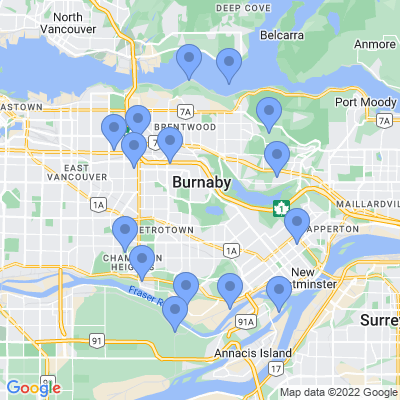

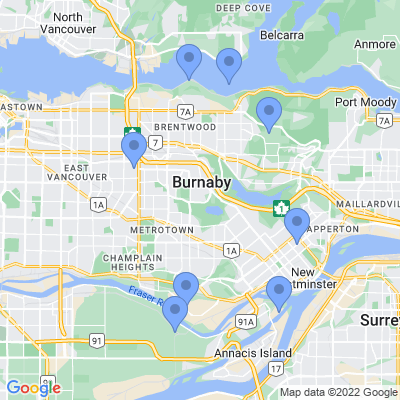

In [92]:
greedy_solution = greedy_solve(matrix)
print(greedy_solution)
display_solution(test_problem_burnaby_center, test_problem_burnaby_locations, greedy_solution, show_coverage=False)

[1, 6, 8, 10, 11, 12, 13, 14]
[[49.220775, -122.915086], [49.181391, -122.998782], [49.250999, -122.929083], [49.204169, -123.021163], [49.292459, -122.961662], [49.190125, -122.92744], [49.262709, -123.04054], [49.294365, -122.989042]]


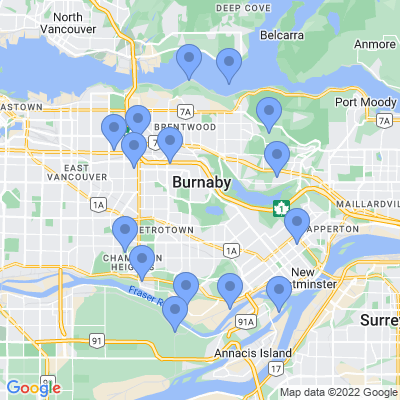

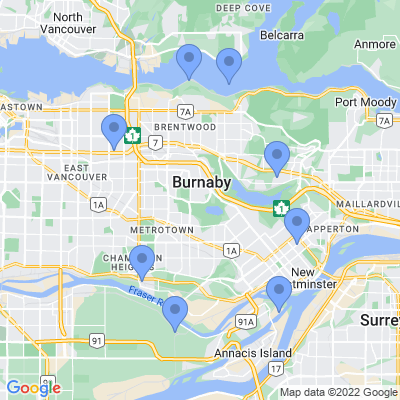

In [93]:
print(linprog_solution)
display_solution(test_problem_burnaby_center, test_problem_burnaby_locations, linprog_solution, show_coverage=False)